# Asteroid clustering

This is a notebook showcasing different ways how asteroids can be clustered together.

The motivation comes from
[another tool I'm working on](https://github.com/MichaelVerdegaal/InfluenceOrbitMapper) for the InfluenceEth game. In
this tool is a neighbours function which is used in a pathfinding algorithm. The problem I had is that the way I
approached it was excruciatingly slow, so I sought a way to precalculate which asteroids are neighbouring which.

The orbit calculation functions come originate the repo above.

## Run this notebook yourself
- Python 3.8+ installed
- Latest .json data export copied to root directory. You can find
  the [direct download link here](https://www.dropbox.com/sh/5g3ww8wi9n0p4s6/AADcR0lgL8iKTQrpiWUC37Oxa?dl=0)
- Install the packages from requirements.txt

In [34]:

from functions import load_asteroids
import numpy as np
import matplotlib.pyplot as plt

asteroids_df = load_asteroids('asteroids_20210917.json')

In [35]:
coords = np.array(asteroids_df['pos'].values.tolist())
x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
print(coords[0])

[-112.3966277   431.18774239   -6.84757389]


[Text(0.5, 1.0, 'Histogram X coordinates'), Text(0, 0.5, 'Frequency')]

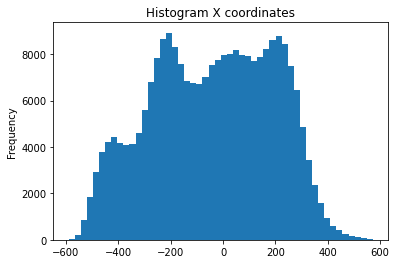

In [36]:
plt.hist(x, bins=50)
plt.gca().set(title='Histogram X coordinates', ylabel='Frequency')

[Text(0.5, 1.0, 'Histogram Y coordinates'), Text(0, 0.5, 'Frequency')]

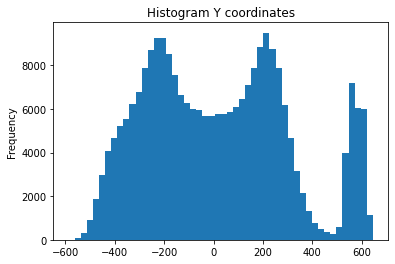

In [37]:
plt.hist(y, bins=50)
plt.gca().set(title='Histogram Y coordinates', ylabel='Frequency')

[Text(0.5, 1.0, 'Histogram Z coordinates'), Text(0, 0.5, 'Frequency')]

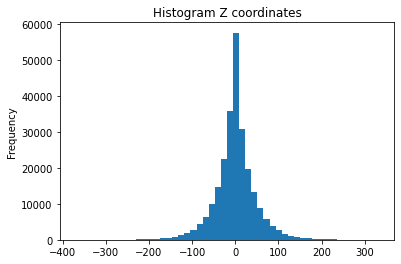

In [38]:
plt.hist(z, bins=50)
plt.gca().set(title='Histogram Z coordinates', ylabel='Frequency')

Text(0.5, 1.0, 'Scatter plot X and Y')

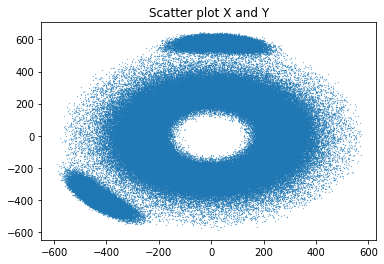

In [39]:
plt.scatter(x, y, s=0.05)
plt.title("Scatter plot X and Y")

## Setting the stage

We have about 250000 total asteroids to work with. Our asteroids are positioned via 3D cartesian coordinates,
consisting of an X, Y and Z, with Z being the height. We'll use the plots above to get some extra information about
them.

### Distribution
We've plotted histograms for each of the coordinate groups. We can see in the X and Y that there are roughly 4 large
groups (which coincides with the next paragraph). Also, visible is that the Z range is a single group and has a lot
smaller range, coming fairly close to a normal distribution.

With this info we can roughly estimate our coordinate plane as [-800/800,-800/800, -400/400]
(bit extra to account for outliers). Combined with the fact that we have this many asteroids, this means that we have
a lot of positions to consider. So extremely slow clustering algorithms may not make the cut.

### Placement

Next, let's look at the scatter plot. We've plotted the X and Y coordinates there, leaving the Z out as it doesn't
matter much for this plot. Clearly visible are 4 separate groups: the inner belt, the outer belt, and 2
trojan clusters. This is a bit harder to see in the main game, but it's similar.

![](https://cdn.discordapp.com/attachments/697855611643232394/904701014987391006/brave_LnODwxWM3X.png)

Although it's nice to have learned this, it doesn't do much good for our clustering practices. So the need here is for
the clustering algorithms to be able to split it up into more than 4 clusters. Something more practical would be
cutting it up like slices (imagine cutting a donut).

Furthermore, some of these asteroids do not comply with these position groups, we name those as the outliers.
As the motivation is a pathfinding algorithm, we don't want to create clusters of say size 1, as this means that
the pathfinding would abrubtly come to a halt in such a case.

### Requirements
Based on the comments above, we will set up the best clustering algorithm as the one that can best adhere to the
conditions below:

- Needs to be able to process a large amount of nodes
- Has to split the asteroids into more than 4 clusters
- Can't create clusters too small (size 1-100)